<a href="https://colab.research.google.com/github/aMV12/disease_prediction/blob/main/Virus_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Импортируем все необходимые библиотеки
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras import backend as K
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

plt.style.use('dark_background')

In [ ]:
#Подключаем google disk и отключем предупреждения
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Указываем пути к снимкам
path = '/content/drive/MyDrive/The_second_XRAY_dataset'
train = path + r'/train'
test = path + r'/test'

In [ ]:
#Указываем новый размер изображений
image_resize = 128

In [ ]:
#Изменяем тренировочный набор изображений для работы с ними
train_ds = keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split = 0.2,
    subset = 'training',
    seed = 125,
    image_size = (image_resize, image_resize),
    batch_size = 32
)

Found 6336 files belonging to 4 classes.
Using 5069 files for training.


In [ ]:
#Изменяем валидационный набор изображений для работы с ними
val_ds = keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (image_resize, image_resize),
    batch_size = 32
)

Found 6336 files belonging to 4 classes.
Using 1267 files for validation.


In [ ]:
#Смотрим названия классов изображений
class_names = train_ds.class_names
class_names

['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

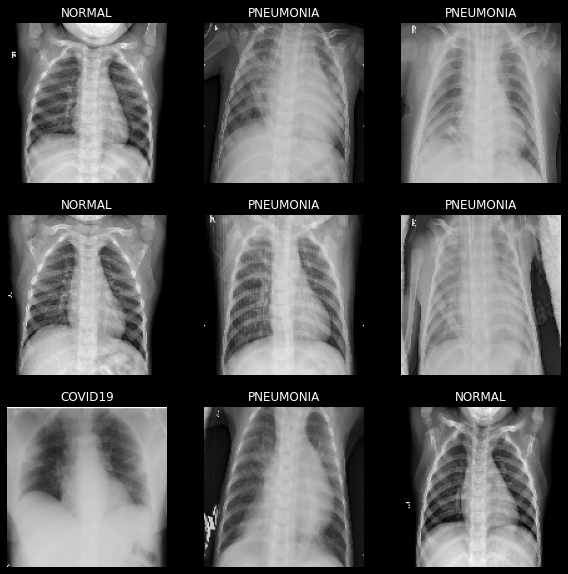

In [ ]:
#Смотрим на сами изображения
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
#Нормализируем набор данных
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.005093444 0.9976793


In [ ]:
#Создаем скелет модели нейронной сети
num_classes = 4
model = Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_resize, image_resize, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
#Создаем функции для оценки качества работы модели
def recall_m(y_true, y_pred):
  true__positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true__positives / (possible_positives + K.epsilon())
  return recall
def precision_m(y_true, y_pred):
  true__positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  precision = true__positives / (predicted_positives + K.epsilon())
  return precision
def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy', recall_m, precision_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
#Обучаем модель на двадцати эпохах
epoches=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epoches)

Epoch 1/20
159/159 [==============================] - 504s 3s/step - loss: 0.4241 - accuracy: 0.8465 - recall_m: 1.6596 - precision_m: 1.6596 - f1_m: 1.6596 - val_loss: 0.1904 - val_accuracy: 0.9321 - val_recall_m: 1.6126 - val_precision_m: 1.6126 - val_f1_m: 1.6126
Epoch 2/20
159/159 [==============================] - 164s 1s/step - loss: 0.1863 - accuracy: 0.9361 - recall_m: 1.6570 - precision_m: 1.6570 - f1_m: 1.6570 - val_loss: 0.1206 - val_accuracy: 0.9676 - val_recall_m: 1.7536 - val_precision_m: 1.7536 - val_f1_m: 1.7536
Epoch 3/20
159/159 [==============================] - 635s 973ms/step - loss: 0.1212 - accuracy: 0.9605 - recall_m: 1.7615 - precision_m: 1.7615 - f1_m: 1.7615 - val_loss: 0.0813 - val_accuracy: 0.9771 - val_recall_m: 1.7996 - val_precision_m: 1.7996 - val_f1_m: 1.7996
Epoch 4/20
159/159 [==============================] - 143s 889ms/step - loss: 0.0950 - accuracy: 0.9661 - recall_m: 1.7858 - precision_m: 1.7858 - f1_m: 1.7858 - val_loss: 0.0795 - val_accuracy: 0

In [ ]:
#Изменяем тестовый набор изображений для работы с ними
test_ds = keras.preprocessing.image_dataset_from_directory(
    test,
    image_size=(image_resize, image_resize),
    batch_size=32
)

Found 771 files belonging to 4 classes.


In [ ]:
#Проходимся по тестовым изображения уже обученной модели и смотрим на метрики модели
model.evaluate(test_ds)

25/25 [==============================] - 122s 3s/step - loss: 3.0605 - accuracy: 0.7691 - recall_m: 1.5040 - precision_m: 1.5040 - f1_m: 1.5040


[3.0604617595672607,
 0.7691310048103333,
 1.5039936304092407,
 1.5039936304092407,
 1.5039935111999512]

In [ ]:
#Пытаемся улучшить модель путем предобработки изображений
data_augmentation = keras.Sequential(
    [
      keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(image_resize, image_resize, 3)),
      keras.layers.experimental.preprocessing.RandomRotation(0.1),
      keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

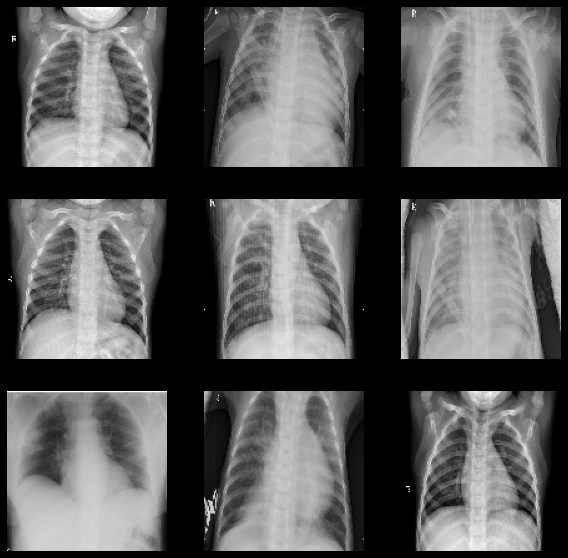

In [ ]:
#Смотрим на сами изображения
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmanted_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
#Создаем скелет новой модели нейронной сети
num_classes = 4
model2 = Sequential([
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_resize, image_resize, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
#Компилируем новую модель
model2.compile(optimizer='adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy', recall_m, precision_m, f1_m])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
#Обучаем новую модель на двадцати эпохах
history = model2.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
159/159 [==============================] - 157s 960ms/step - loss: 0.7274 - accuracy: 0.7230 - recall_m: 1.6018 - precision_m: 1.6018 - f1_m: 1.6018 - val_loss: 0.3898 - val_accuracy: 0.8485 - val_recall_m: 1.7524 - val_precision_m: 1.7524 - val_f1_m: 1.7524
Epoch 2/20
159/159 [==============================] - 152s 942ms/step - loss: 0.3713 - accuracy: 0.8647 - recall_m: 1.6023 - precision_m: 1.6023 - f1_m: 1.6023 - val_loss: 0.3181 - val_accuracy: 0.8808 - val_recall_m: 1.7726 - val_precision_m: 1.7726 - val_f1_m: 1.7726
Epoch 3/20
159/159 [==============================] - 155s 965ms/step - loss: 0.3044 - accuracy: 0.8915 - recall_m: 1.6326 - precision_m: 1.6326 - f1_m: 1.6326 - val_loss: 0.2396 - val_accuracy: 0.9116 - val_recall_m: 1.6968 - val_precision_m: 1.6968 - val_f1_m: 1.6968
Epoch 4/20
159/159 [==============================] - 150s 933ms/step - loss: 0.2601 - accuracy: 0.9079 - recall_m: 1.6206 - precision_m: 1.6206 - f1_m: 1.6206 - val_loss: 0.1900 - val_accur

In [ ]:
#Проходимся по тестовым изображения уже обученной модели и смотрим на метрики модели
model2.evaluate(test_ds)

25/25 [==============================] - 13s 376ms/step - loss: 0.5853 - accuracy: 0.8301 - recall_m: 1.8068 - precision_m: 1.8068 - f1_m: 1.8068


[0.5853308439254761,
 0.8300908207893372,
 1.8068383932113647,
 1.8068383932113647,
 1.8068383932113647]

In [ ]:
#Сохраняем первую обученную модель
model.save('/content/drive/MyDrive/CNN.h5')

In [ ]:
#Сохраняем вторую обученную модель
model2.save('/content/drive/MyDrive/CNN2.h5')

In [ ]:
#Создаем скелет новой модели нейронной сети, уже с большим числом слоев
num_classes = 4
model3 = Sequential([
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_resize, image_resize, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
#Компилируем новую модель
model3.compile(optimizer='adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy', recall_m, precision_m, f1_m])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
#Обучаем новую модель на тридцати эпохах
history = model3.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
159/159 [==============================] - 194s 1s/step - loss: 0.7292 - accuracy: 0.7134 - recall_m: 1.8386 - precision_m: 1.8386 - f1_m: 1.8386 - val_loss: 0.5056 - val_accuracy: 0.8003 - val_recall_m: 2.0086 - val_precision_m: 2.0086 - val_f1_m: 2.0086
Epoch 2/30
159/159 [==============================] - 178s 1s/step - loss: 0.3828 - accuracy: 0.8554 - recall_m: 1.8690 - precision_m: 1.8690 - f1_m: 1.8690 - val_loss: 0.3758 - val_accuracy: 0.8713 - val_recall_m: 1.9161 - val_precision_m: 1.9161 - val_f1_m: 1.9161
Epoch 3/30
159/159 [==============================] - 183s 1s/step - loss: 0.2918 - accuracy: 0.8919 - recall_m: 1.7906 - precision_m: 1.7906 - f1_m: 1.7906 - val_loss: 0.2645 - val_accuracy: 0.9053 - val_recall_m: 1.8955 - val_precision_m: 1.8955 - val_f1_m: 1.8955
Epoch 4/30
159/159 [==============================] - 181s 1s/step - loss: 0.2392 - accuracy: 0.9144 - recall_m: 1.7608 - precision_m: 1.7608 - f1_m: 1.7608 - val_loss: 0.2015 - val_accuracy: 0.9258 

In [ ]:
#Проходимся по тестовым изображения уже обученной модели и смотрим на метрики модели
model3.evaluate(test_ds)

25/25 [==============================] - 21s 519ms/step - loss: 0.7577 - accuracy: 0.8236 - recall_m: 1.8027 - precision_m: 1.8027 - f1_m: 1.8027


[0.7577420473098755,
 0.8236057162284851,
 1.802740454673767,
 1.802740454673767,
 1.802740454673767]

In [ ]:
#Сохраняем новую модель
model3.save('/content/drive/MyDrive/CNN3.h5')

In [ ]:
#Импортируем обученную модель
new_model = keras.models.load_model('/content/drive/MyDrive/CNN3.h5', custom_objects={'recall_m':recall_m, 'precision_m':precision_m, 'f1_m':f1_m})

In [ ]:
#Импортируем необходимую библиотеку
import cv2

In [ ]:
#Указываем путь к снимку, который мы хотим проанализировать и слегка видоизменяем его
test_path = '/content/drive/MyDrive/The_second_XRAY_dataset/test/COVID19/COVID19(460).jpg'
test_image = cv2.imread(test_path)
test_image = cv2.resize(test_image, (image_resize, image_resize))
test_image.shape

(128, 128, 3)

In [ ]:
#Смотрим предсказание
predictions = new_model.predict(np.array([test_image]))
predictions

1/1 [==============================] - 0s 231ms/step


array([[ 2.2802334,  1.5574566,  1.5067352, -7.3290854]], dtype=float32)

In [ ]:
#Смотрим оценку качества предсказания
score = tf.nn.softmax(predictions)
print(class_names[np.argmax(score)], 100*np.max(score))

COVID19 51.364606618881226


Text(0.5, 1.0, 'Предсказание COVID19')

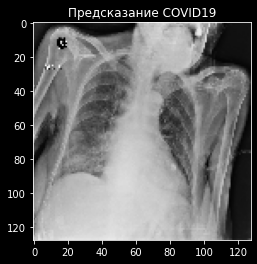

In [ ]:
#Визуализируем наш снимок
plt.imshow(test_image)
plt.title('Предсказание ' + class_names[np.argmax(score)])

При написании кода программы было перепробовано несколько вариантов обучения с предобработкой снимков грудной клетки и без, а также с увеличением числа слоев нейронной сети и увеличением числа эпох. По птогу лучшим результатом является точность - 81%. Программу можно продолжать совершенствовать посредством смены модели нейронной сети на более сложную, увеличением числа материала для обучения сети, а также более тшательной предобработкой снимков и увеличением числа эпох. В таком случаем возможно будет повысить точность >90%, но, к сожалению, чем лучше работает модель, тем больше и совершенией требуются вычислительные мощности, конми я не обладаю. Поэтому я считаю, что результат -81% вполне приемлем для домашней станции проверки снимков на какое-либо заболевание.